# Declaration of Originality

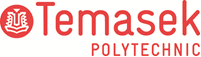

**TEMASEK POLYTECHNIC**
<br>**SCHOOL OF INFORMATICS & IT**
<br>**DIPLOMA IN INFORMATION TECHNOLOGY**
<br>**MACHINE LEARNING FOR DEVELOPERS (CAI2C08)**
<br>**AY2025/2026 OCTOBER SEMESTER**

**PROJECT PROGRAM CODES**
* Student Name (Matric Number)  : Nathan
* Tutorial Group                : 
* Tutor						    :  
* Submission Date               : 


**Declaration of Originality**
* I am the originator of this work and I have appropriately acknowledged all other original sources used as my references for this work.
* I understand that Plagiarism is the act of taking and using the whole or any part of another person’s work, including work generated by AI, and presenting it as my own.
* I understand that Plagiarism is an academic offence and if I am found to have committed or abetted the offence of plagiarism in relation to this submitted work, disciplinary action will be enforced.

# Libraries

In [20]:
## Import libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib


# 1. Business Understanding
Goal: ?

# 2. Data Understanding

## 2.1 Load dataset

In [21]:
## Read *.csv file into pandas DataFrame
FILE_PATH = r"Energy Production Dataset.csv"  # <-- change if needed
df = pd.read_csv(FILE_PATH)
df

# Parse date and sort (important for time-based split)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Date", "Start_Hour"]).reset_index(drop=True)

print(df.head())
print(df.info())

        Date  Start_Hour  End_Hour Source  Day_of_Year   Day_Name Month_Name  \
0 2020-01-01           0         1   Wind            1  Wednesday    January   
1 2020-01-01           1         2   Wind            1  Wednesday    January   
2 2020-01-01           2         3   Wind            1  Wednesday    January   
3 2020-01-01           3         4   Wind            1  Wednesday    January   
4 2020-01-01           4         5   Wind            1  Wednesday    January   

   Season  Production  
0  Winter        3542  
1  Winter        2932  
2  Winter        2725  
3  Winter        2761  
4  Winter        2708  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51864 entries, 0 to 51863
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         51864 non-null  datetime64[ns]
 1   Start_Hour   51864 non-null  int64         
 2   End_Hour     51864 non-null  int64         
 3   Source       5186

## 2.2 Summary Statistics

In [15]:
## Understand the type of variable for each column
print("\nMissing values:\n", df.isna().sum())
print("\nTarget summary (Production):\n", df["Production"].describe())



Missing values:
 Date           0
Start_Hour     0
End_Hour       0
Source         0
Day_of_Year    0
Day_Name       0
Month_Name     0
Season         0
Production     0
dtype: int64

Target summary (Production):
 count    51864.000000
mean      6215.069933
std       3978.364965
min         58.000000
25%       3111.000000
50%       5372.000000
75%       8501.000000
max      23446.000000
Name: Production, dtype: float64


In [ ]:
## Check for missing data


In [ ]:
## Describe data distribution


## 2.3 Data Visualization

### 2.3.1 Understanding distribution of data

### 2.3.1.1 Understanding distribution of target

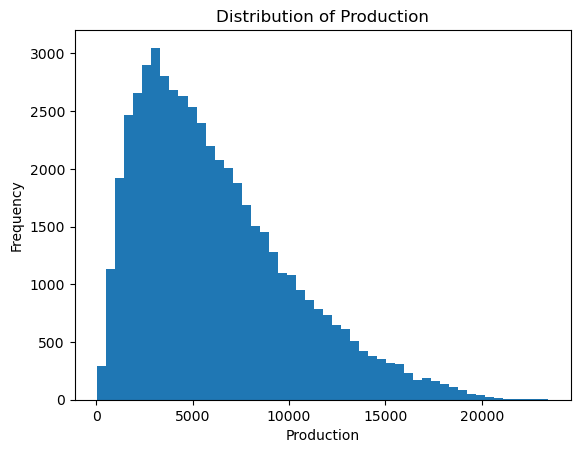

In [16]:
## Understanding distribution of target
# --- Target distribution: Production ---
plt.figure()
plt.hist(df["Production"], bins=50)
plt.title("Distribution of Production")
plt.xlabel("Production")
plt.ylabel("Frequency")
plt.show()


### 2.3.1.2 Understanding distribution of features

<Figure size 640x480 with 0 Axes>

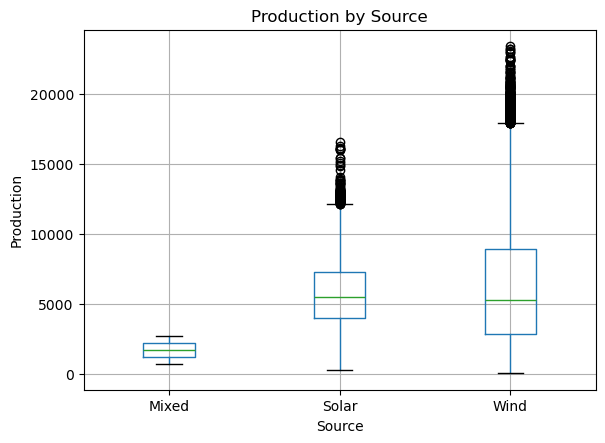

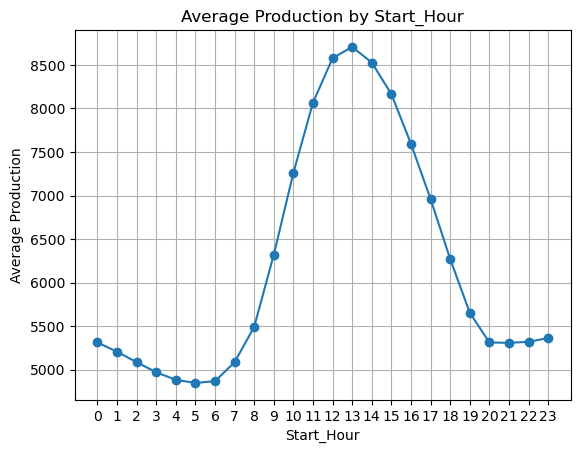

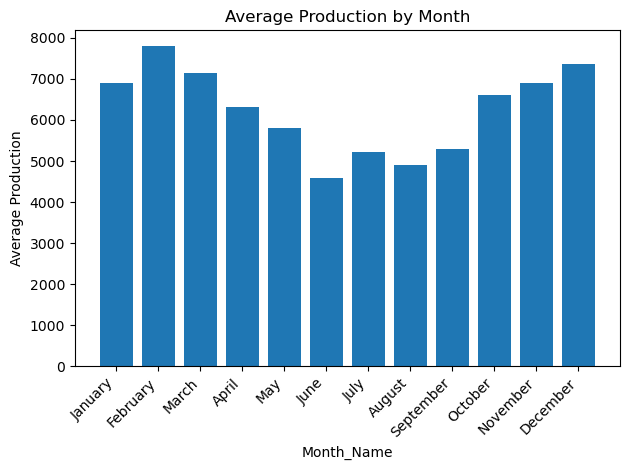

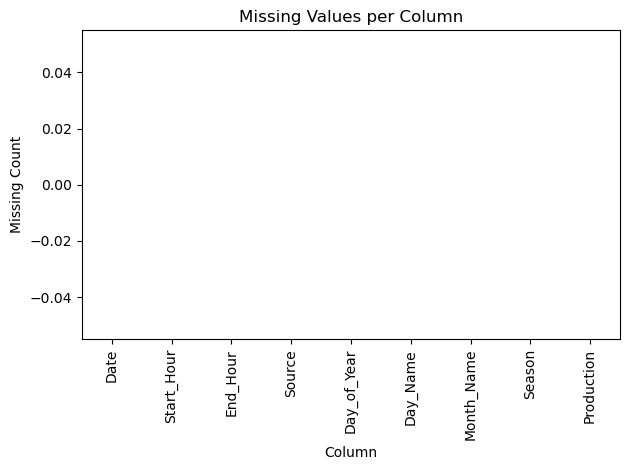

In [17]:
## Understanding distribution of features
# --- Production by Source (boxplot) ---
plt.figure()
df.boxplot(column="Production", by="Source")
plt.title("Production by Source")
plt.suptitle("")  # removes automatic pandas subtitle
plt.xlabel("Source")
plt.ylabel("Production")
plt.show()

# --- Production by Start_Hour (average trend) ---
hourly_mean = df.groupby("Start_Hour")["Production"].mean()
plt.figure()
plt.plot(hourly_mean.index, hourly_mean.values, marker="o")
plt.title("Average Production by Start_Hour")
plt.xlabel("Start_Hour")
plt.ylabel("Average Production")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# --- Production by Month_Name (average) ---
month_order = ["January","February","March","April","May","June",
               "July","August","September","October","November","December"]

monthly_mean = df.groupby("Month_Name")["Production"].mean().reindex(month_order)

plt.figure()
plt.bar(monthly_mean.index, monthly_mean.values)
plt.title("Average Production by Month")
plt.xlabel("Month_Name")
plt.ylabel("Average Production")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- Optional: check missing values visually ---
plt.figure()
(df.isna().sum().sort_values(ascending=False)).plot(kind="bar")
plt.title("Missing Values per Column")
plt.xlabel("Column")
plt.ylabel("Missing Count")
plt.tight_layout()
plt.show()

### 2.3.2 Understanding relationship between variables

In [ ]:
## Understanding relationship between variables


# 3. Data Preparation

## 3.1 Data Cleaning

In [5]:
## Clean data
# End_Hour is redundant (always Start_Hour + 1 mod 24), so we drop it.
target_col = "Production"

feature_cols = [
    "Start_Hour",
    "Day_of_Year",
    "Source",
    "Day_Name",
    "Month_Name",
    "Season"
]

X = df[feature_cols].copy()
y = df[target_col].copy()


## 3.2 Train-Test Split

In [6]:
## Split data into train set and test set
# We'll split by time order (first 80% train, last 20% test)
split_idx = int(len(df) * 0.8)

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]

X_test  = X.iloc[split_idx:]
y_test  = y.iloc[split_idx:]

print("\nTrain size:", X_train.shape, "Test size:", X_test.shape)



Train size: (41491, 6) Test size: (10373, 6)


# 4. Modelling

### 4.2 Train Model

In [7]:
## Initialise and train model
numeric_features = ["Start_Hour", "Day_of_Year"]
categorical_features = ["Source", "Day_Name", "Month_Name", "Season"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

model = LinearRegression()

pipe_linr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model)
])

In [8]:
pipe_linr.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# 5. Model Evaluation

In [10]:
## Evaluate model
y_pred = pipe_linr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Results")
print("MAE :", mae)
print("MSE :", mse)
print("RMSE:", rmse)
print("R^2 :", r2)


Linear Regression Results
MAE : 3514.1137540383747
MSE : 20549637.886991024
RMSE: 4533.170842466785
R^2 : -0.06560665600679205


In [ ]:
## New data
new_data = pd.DataFrame([{
    "Start_Hour": 14,
    "Day_of_Year": 120,
    "Source": "Solar",
    
    "Day_Name": "Monday",
    "Month_Name": "April",
    "Season": "Spring"
}])

## Predict
pred = pipe_linr.predict(new_data)[0]
print("\nPrediction for new data:", pred)


Prediction for new data: 6583.369666453445


## 6. Save model (For Streamlit)


In [22]:
## Further feature engineering / feature selection
joblib.dump(pipe_linr, "energy_linr_pipeline.pkl")
print("\nSaved: energy_linr_pipeline.pkl")


Saved: energy_linr_pipeline.pkl
